In [ ]:
!pip install segmentation-models-pytorch --quiet
!pip install albumentations --quiet
# 1. Importing Required Libraries
import os
import torch
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
from torchvision import transforms
from sklearn.model_selection import train_test_split

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_dir = '/content/drive/MyDrive/SpaceVela 3D-CV 1 class fail.v1i.yolov11.zip (Unzipped Files)'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_images_dir = os.path.join(base_dir, 'train/images')
train_labels_dir = os.path.join(base_dir, 'train/labels')

val_images_dir = os.path.join(base_dir, 'valid/images')
val_labels_dir = os.path.join(base_dir, 'valid/labels')


In [ ]:
# 3. Function to Convert YOLO Polygon Annotations to Masks
def yolo_polygon_to_mask(yolo_annotations, img_size):
    mask = np.zeros(img_size, dtype=np.uint8)
    h, w = img_size

    for annotation in yolo_annotations:
        parts = annotation.strip().split()
        class_id = int(parts[0])
        coords = list(map(float, parts[1:]))

        # Convert normalized coordinates to pixel values
        polygon = []
        for i in range(0, len(coords), 2):
            x = int(coords[i] * w)
            y = int(coords[i + 1] * h)
            polygon.append([x, y])

        polygon = np.array(polygon, dtype=np.int32)

        # Fill polygon on mask
        cv2.fillPoly(mask, [polygon], 1)

    return mask

In [ ]:
# 4. Custom Dataset Class
class DefectDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None):
        self.images_dir = images_dir
        self.labels_dir = labels_dir
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.png'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        label_path = os.path.join(self.labels_dir, self.image_files[idx].rsplit('.', 1)[0] + '.txt')

        image = Image.open(img_path).convert("RGB")
        img_size = image.size[::-1]  # (height, width)

        with open(label_path, 'r') as f:
            yolo_annotations = f.readlines()

        mask = yolo_polygon_to_mask(yolo_annotations, img_size)
        mask = Image.fromarray(mask)

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [ ]:
# 5. Transformations for Images and Masks
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 6. Loading Data
train_dataset = DefectDataset(train_images_dir, train_labels_dir, transform=transform)
val_dataset = DefectDataset(val_images_dir, val_labels_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
# 7. Initialize U-Net Model
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1)
model = model.to(device)

# 8. Define Loss Function and Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import cv2
# 9. Training the Model
num_epochs = 4
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        outputs = model(images)
        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

    val_losses.append(val_loss / len(val_loader))

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

print('Training Complete!')


Epoch [1/4], Train Loss: 0.0420, Val Loss: 0.0063
Epoch [2/4], Train Loss: 0.0044, Val Loss: 0.0088
Epoch [3/4], Train Loss: 0.0035, Val Loss: 0.0085
Epoch [4/4], Train Loss: 0.0033, Val Loss: 0.0179
Training Complete!


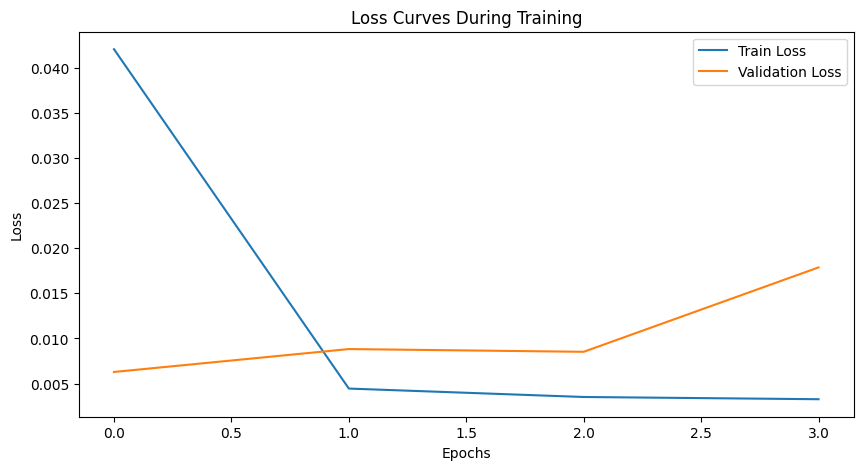

In [ ]:
# 10. Visualizing Training Results
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves During Training')
plt.show()


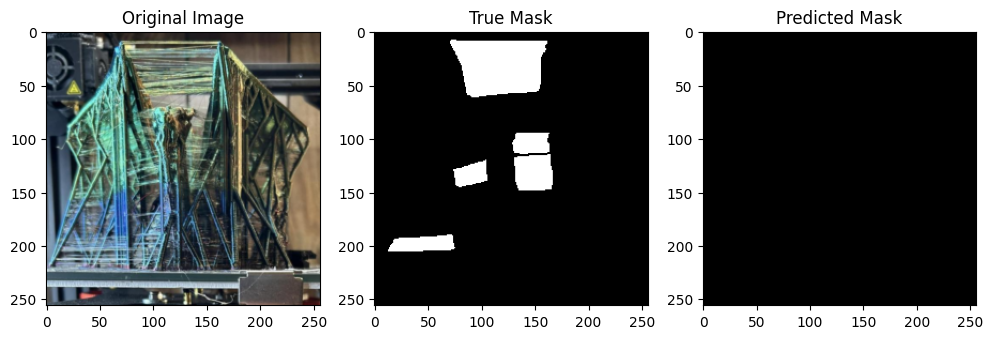

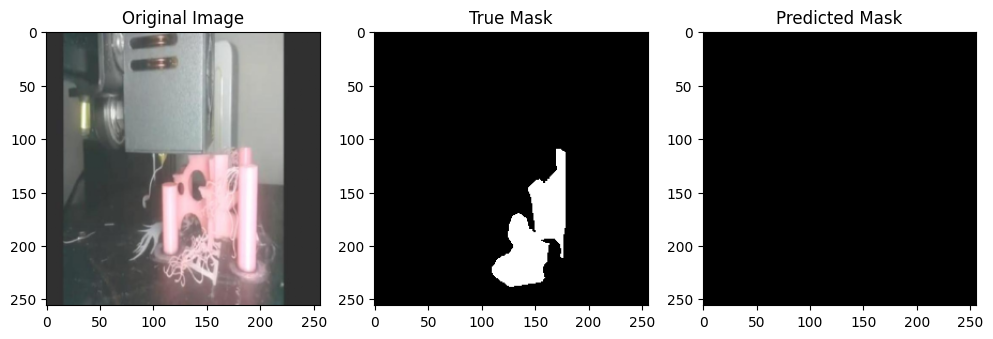

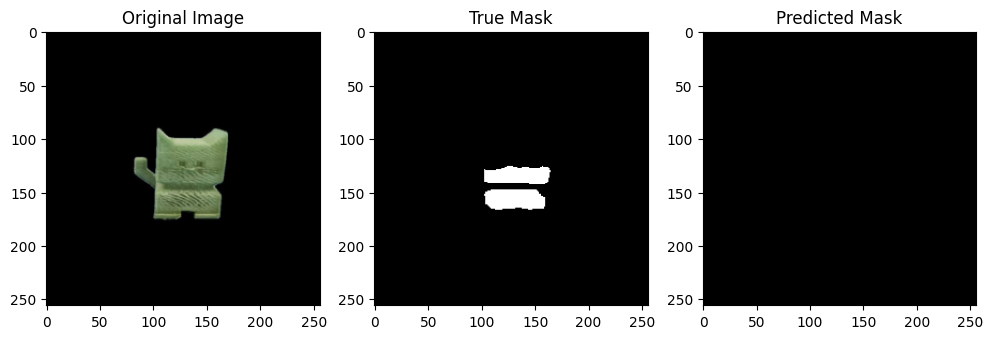

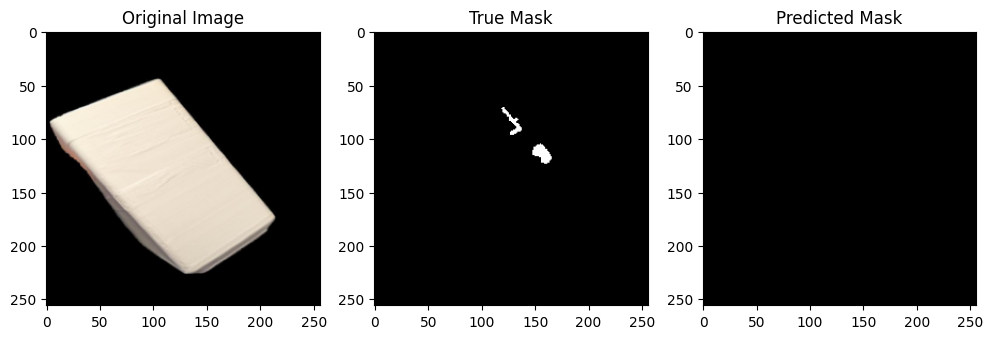

In [ ]:
# 11. Visualizing Predictions
model.eval()
with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()

        for i in range(len(images)):
            img = images[i].cpu().permute(1, 2, 0).numpy()
            mask = masks[i].cpu().squeeze().numpy()
            pred = preds[i].squeeze()

            fig, axs = plt.subplots(1, 3, figsize=(12, 4))
            axs[0].imshow(img)
            axs[0].set_title('Original Image')
            axs[1].imshow(mask, cmap='gray')
            axs[1].set_title('True Mask')
            axs[2].imshow(pred > 0.5, cmap='gray')
            axs[2].set_title('Predicted Mask')
            plt.show()
        break
